In [276]:
#Load usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [277]:
#Task 1
#The first task consists of fitting the following equation to a set of 50 x/y data points using the polyfit() function from Numpy.

#Load the data and define the feature and target:
task1_df = pd.read_csv('~/Desktop/EPFL Applied ML/task-1.csv') #change path as needed
x = task1_df.x.values
y = task1_df.y.values

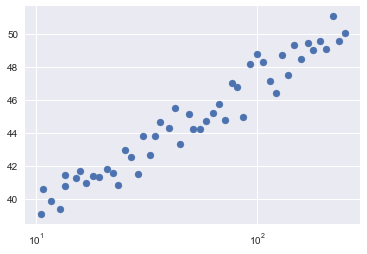

In [278]:
#Have a peek at the data to check the type of relation:
sns.set()
plt.scatter(x, y)
plt.xscale('log')

#Looks like a linear relationship, so linear is a good first choice.

In [279]:
#Fit the equation using polyfit() and print the a, b parameters.

coef, intercept = np.polyfit(np.log(x), y, deg=1) #coefficient and intercept of a linear fit of y VS log(x)
print('slope (a): {:.2f}'.format(coef))
print('intercept (b): {:.2f}'.format(intercept))

slope (a): 3.39
intercept (b): 31.53


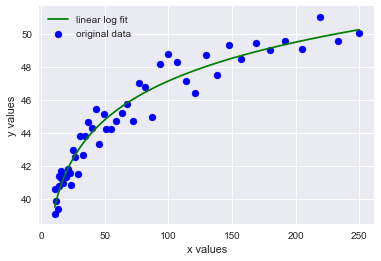

In [280]:
#Plot your model with the 50 data points, i.e., the curve that corresponds to the equation from above.

x_values = np.linspace(min(x), max(x), num=100) #define an array of x values
y_fit = np.polyval(np.polyfit(np.log(x), y, deg=1), np.log(x_values)) #calculate the y values based on the (log)new array and then fit to the original data

sns.set()
plt.scatter(x, y, c='blue', label='original data')
plt.plot(x_values, y_fit, c='green', label='linear log fit')
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.show()

In [281]:
#Compute and print the R2 coefficient using Numpy.

def R2(y, y_pred): #define an R squared function based on its definition
    SST = np.sum(np.square(y - np.mean(y)))
    SSR = np.sum(np.square(y - y_pred))
    R2 = 1 - SSR/SST
    return R2

y_pred = np.polyval(np.polyfit(np.log(x), y, deg=1), np.log(x)) #calculate y predictions based on the linear fit
R2_coef = R2(y, y_pred)
print('R2 coefficient: {:.4f}'.format(R2_coef))

R2 coefficient: 0.9412


Polyfit() finds a set of coefficients w that minimizes the residual sum of squares for y_pred = wX. This implies an analytical solution of the type w = (XT.X)^(-1).XT.y

Gradient descent is an iterative method that depends on the function gradient + a learning rate and can minimize a variety of cost functions, while polyfit uses an analytical solution that minimizes the residual sum of squares only. Polyfit can only handle simple linear regressions while gradient descent can handle regressions with multiple features.  

In [282]:
#Task 2
#In the second task, you have to fit a linear regression model to a data set which contains outliers. This time, you can use the estimators from the Scikit-learn library. The data consists of three features x1, x2, x3 and a target variable y. Here are the first five rows.

#Load and split the data into 80-20 train/test sets using train_test_split(). Set the random_state to zero.
task2_df = pd.read_csv('~/Desktop/EPFL Applied ML/task-2.csv') #change path as needed
task2_train, task2_test = train_test_split(task2_df, train_size=0.8, test_size=0.2, random_state=0) #split the original dataframe into train and test dataframes, with a 80/20 weight.

X_tr, y_tr = task2_train.drop(columns='y').values, task2_train.y.values #get target and feature arrays from the training dataframe
X_te, y_te = task2_test.drop(columns='y').values, task2_test.y.values #get the target and feature arrays from the test dataframe

In [283]:
#Fit and evaluate a linear regression using the train/test set methodology. Print the mean absolute error (MAE) on the test set.

def MAE(y, y_pred): #use a function to define the mean absolute error
    return np.mean(np.abs(y - y_pred))

lr = LinearRegression().fit(X_tr, y_tr) #fit a linear regression using the train set

print('Train set MAE: {:.4f}'.format(MAE(y_tr, lr.predict(X_tr)))) #MAE of the regression for the train set
print('Test set MAE: {:.4f}'.format(MAE(y_te, lr.predict(X_te)))) #MAE of the regression for the test set. It is even better that the train set one!

#MAE values are similar for train and test, which is an indication that there is no overfitting of the model.

Train set MAE: 119.6664
Test set MAE: 104.7884


In [284]:
#Improve your test MAE by removing outliers from the train set.

def z_score(x): #use a function to define the z_score. Might also use scale from scikit preprocessing module
    return (x - np.mean(x, axis=0))/np.std(x, axis=0) #add axis=0 so that the z_score is computed for each column in case the input array has several columns

#To handle the removal of the outliers, we will do it directly from the original dataframe, and then split it back to get the train target and feature arrays without outliers.
task2_train_filtered = task2_train[np.abs(z_score(task2_train))<2] #returned dataframe assigns NaN values to all the elements whose absolute value of the z_score is larger than 2. Shape is 800 x 4
task2_train_filtered = task2_train_filtered.dropna(how='any', axis=0) #drops all the rows where there is any NaN value. Shape is 721 x 4, so 79 outliers were removed. 
#This removal represents almost 10% of the data, so the operation might actually be too harsh and we could consider to set the z_score to 3 rather than 2. After checking this case, the difference is not as extreme as expected.

X_tr_filt, y_tr_filt = task2_train_filtered.drop(columns='y').values, task2_train_filtered.y.values #get target and feature arrays from the training dataframe without outliers

lr_filt = LinearRegression().fit(X_tr_filt, y_tr_filt) #fit a linear regression using the train set without outliers

print('Train set MAE, linear without outliers: {:.4f}'.format(MAE(y_tr_filt, lr_filt.predict(X_tr_filt)))) #MAE of the regression for the train set without outliers
print('Test set MAE, linear without outliers: {:.4f}'.format(MAE(y_te, lr_filt.predict(X_te)))) #MAE of the regression for the test set using the train set without outliers as input.

#Test MAE was greatly improved by removing the outliers from the train set.

Train set MAE, linear without outliers: 52.8395
Test set MAE, linear without outliers: 67.8309


In [285]:
#Fit a linear regression with Huber loss (using the train points with outliers). Print its MAE on the test set.

huber = HuberRegressor(epsilon=1.35).fit(X_tr_filt, y_tr_filt) #fit a linear regression with Huber loss using the train set without outliers

print('Test set MAE, Huber without outliers: {:.4f}'.format(MAE(y_te, huber.predict(X_te)))) #MAE of the regression for the test set using the train set without outliers as input and a linear regression with Huber loss.

#Test MAE is improved compared to the case with outliers, but the linear case without outliers continues to yield the best results, which seems somehow counterintuitive. 

Test set MAE, Huber without outliers: 69.0807


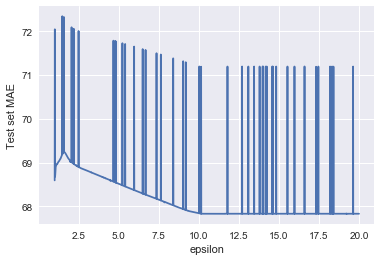

In [287]:
#To double check whether the epsilon parameter plays a role, a sweep through several values will be done to see if the MAE value can be optimized.
epsilons = np.linspace(1, 20, num=2000) #the number of points is a bit exaggerated, but it shows how the number of spikes increases in the final MAE value as we take smaller epsilon intervals. 

mae_values = [] #empty list that will be filled with the values in the for loop

for eps_value in epsilons: #might take more than 30 seconds to run
    huber_fit = HuberRegressor(epsilon=eps_value).fit(X_tr_filt, y_tr_filt) #fit the model
    mae_value = MAE(y_te, huber_fit.predict(X_te)) #calculate MAE
    mae_values.append(mae_value) #append the values before going on with the loop

plt.plot(epsilons, mae_values) #plot mae values in terms of epsilon
plt.xlabel('epsilon')
plt.ylabel('Test set MAE')
plt.show()
#It can be seen that the best MAE values are obtained for epsilons larger than 10. Also the overall MAE value stabilizes above this epsilon threshold, with the exception of the random (?) spikes.

In [288]:
#If a linear regression with Huber loss is fitted for an epsilon of 11 for example:

huber = HuberRegressor(epsilon=11).fit(X_tr_filt, y_tr_filt) #fit a linear regression with Huber loss using the train set without outliers, for an optimized epsilon value

print('Test set MAE, Huber without outliers, optimized epsilon: {:.4f}'.format(MAE(y_te, huber.predict(X_te)))) #MAE of the regression for the test set using the train set without outliers as input and a linear regression with Huber loss and an optimized epsilon.

#Test MAE is exactly the same one as the linear regression without outliers, and it has been improved in comparison to the epsilon=1.35 case.

Test set MAE, Huber without outliers, optimized epsilon: 67.8309


In [289]:
#Task 3
#The goal of the third task is to fit a polynomial regression of degree 10 to the following set of 50 x/y data points. You will have to apply regularization to avoid overfitting.

#Load and split data into 50-50 train/test sets using train_test_split(). Set the random_state to zero.
task3_df = pd.read_csv('~/Desktop/EPFL Applied ML/task-3.csv') #change path as needed
x3 = task3_df.x.values
y3 = task3_df.y.values

x3_tr, x3_te, y3_tr, y3_te = train_test_split(
    x3, y3, train_size=0.5, test_size=0.5, random_state=0) #split the original dataframe into train and test dataframes, with a 50/50 weight.

In [290]:
#Fit a polynomial of degree 10 to the train set. Print its residual sum of squares (RSS) on the train/test sets. Does your model overfit?
pf_obj = PolynomialFeatures(degree=10, include_bias=False) #define polynomial features of degree 10, setting include_bias to False to avoid the zeroth order term
X_tr_pf = pf_obj.fit_transform(x3_tr[:, np.newaxis]) #transform the features on the training set
X_te_pf = pf_obj.fit_transform(x3_te[:, np.newaxis]) #transform the features on the test set

lr_poly10 = LinearRegression().fit(X_tr_pf, y3_tr) #linear regression with poly10 features

def RSS(y, y_pred): #use a function to define the residual sum of squares
    return np.sum(np.square(y - y_pred))

print('Train set RSS: {:.4f}'.format(RSS(y3_tr, lr_poly10.predict(X_tr_pf)))) #RSS of the regression for the train set
print('Test set RSS: {:.4f}'.format(RSS(y3_te, lr_poly10.predict(X_te_pf)))) #RSS of the regression for the test set

#The RSS value of the test set is more than double the RSS value of the training set, so there are serious suspicions that the model is overfitting the data.

Train set RSS: 0.6841
Test set RSS: 1.5137


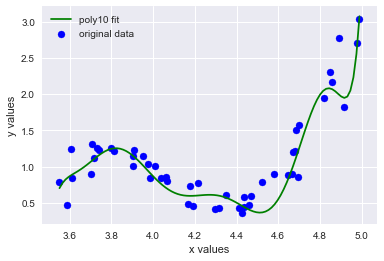

In [292]:
#Plot your model with the 50 data points, i.e., the curve that corresponds to your polynomial regression.
x3_values = np.linspace(min(x3), max(x3), num=100) #define an array of x values
X3_pf = pf_obj.fit_transform(x3_values[:, np.newaxis]) #apply the transformation to the array
y3_poly10 = lr_poly10.predict(X3_pf) #calculate the y values based on the (log)new array and the poly10 linear regression

sns.set()
plt.scatter(x3, y3, c='blue', label='original data') #original data
plt.plot(x3_values, y3_poly10, c='green', label='poly10 fit') #fitted curve
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.show()

#indeed, the model overfits the data

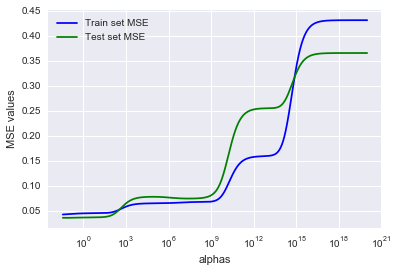

In [293]:
#Apply regularization using ridge regression. Tune the regularization strength using grid search.
#Note: fixing the poly10 already simplifies the ridge tuning.
alphas = np.logspace(-1.45, 20, num=1000) #generate an alpha array with 100 values in logscale (from 10^-3 to 10^20)

mse_tr = [] #empty list that will be filled with the train set rss values in the for loop
mse_te = [] #empty list that will be filled with the test set rss values in the for loop

for alpha in alphas: #run through the alpha values
    ridge = Ridge(alpha=alpha).fit(X_tr_pf, y3_tr) #apply ridge regression to train set with poly10 features
    mse_values_tr = mse(y3_tr, ridge.predict(X_tr_pf)) #calculate corresponding mse for train set
    mse_tr.append(mse_values_tr) #append to mse train array
    mse_values_te = mse(y3_te, ridge.predict(X_te_pf)) #calculate corresponding mse for test set
    mse_te.append(mse_values_te) #append to mse test array

plt.plot(alphas, mse_tr, c='blue', label='Train set MSE') #plot train set mse VS alpha
plt.plot(alphas, mse_te, c='green', label='Test set MSE') #plot test set mse VS alpha
plt.xlabel('alphas')
plt.ylabel('MSE values')
plt.xscale('log')
plt.legend()
plt.show()

Best alpha: 6.75e-02
Train set RSS, best alpha: 1.0779
Test set RSS, best alpha: 0.8998


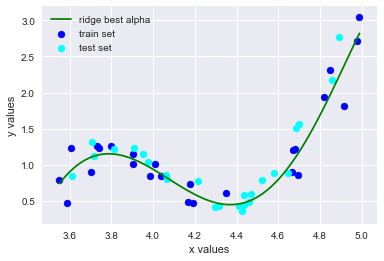

In [294]:
#Compute the train/test RSS of your (tuned) ridge regression model and plot the new curve.
best_alpha = alphas[np.argmin(mse_te)] #extract best alpha that yields the minimum corresponding value for the test set mse
ridge_best = Ridge(alpha=best_alpha).fit(X_tr_pf, y3_tr) #apply ridge regression

print('Best alpha: {:.2e}'.format(best_alpha)) #best alpha value
print('Train set RSS, best alpha: {:.4f}'.format(RSS(y3_tr, ridge_best.predict(X_tr_pf)))) #RSS for the best alpha ridge regression of the train set
print('Test set RSS, best alpha: {:.4f}'.format(RSS(y3_te, ridge_best.predict(X_te_pf)))) #RSS for the best alpha ridge regression of the test set

sns.set()
plt.scatter(x3_tr, y3_tr, c='blue', label='train set') #train set plot
plt.scatter(x3_te, y3_te, c='cyan', label='test set') #test set plot
plt.plot(x3_values, ridge_best.predict(X3_pf), c='green', label='ridge best alpha') #best alpha ridge regression 
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.show()